# Fink case study: extragalactic science

<img src="../Fink_PrimaryLogo_WEB.jpg" width=300 />

## Goal

The goal of this notebook is to show how Fink can contribute to extragalactic science. This notebook includes queries for Active Galactic Nucleii and Supernova science. 

## What is behind?

This notebook will use:
- Fink cross-match with close by sources using CDS xmatch service.
- Fink's machine learning classification scores [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173)  and Random Forest [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract)

# 1st case study: known AGNs

### API query: latest alerts associated with known AGNs
Query latest n=5 alerts spatially coincident with a catalogued AGN in the CDS Simbad catalogue

In [1]:
import requests
import pandas as pd

# Get latests 100 alerts linked to AGNs
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': 'AGN', # tag from CDSxmatch service
    'n': '5' # number of alerts
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

This table contains all alerts linked to a CDS catalogue AGN. This includes
- Alert information from ZTF processing (just latest photometry points)
- Fink's added values

In [2]:
pdf

,d:cdsxmatch,d:mulens_class_1,d:mulens_class_2,d:rfscore,d:roid,d:snn_sn_vs_all,d:snn_snia_vs_nonia,i:candid,i:chipsf,i:classtar,...,i:ssdistnr,i:ssmagnr,i:ssnamenr,i:tooflag,i:xpos,i:ypos,v:classification,v:r-g,v:rate(r-g),v:lastdate
0,AGN,,,0.082,0,0.269190,0.758698,1540394073115010001,1.257728,0.951,...,-999,-999,null,0,1229.8586,1813.2150,AGN,NaN,NaN,2021-03-21 09:27:28.002
1,AGN,,,0.108,0,0.027196,0.714365,1540391700615010001,2.450012,0.982,...,-999,-999,null,0,1663.2775,114.3680,AGN,NaN,NaN,2021-03-21 09:24:03.001
2,AGN,VARIABLE,CONSTANT,0.090,0,0.796453,0.892758,1540382924815010001,1.477278,0.703,...,-999,-999,null,0,798.9005,1309.9648,AGN,NaN,NaN,2021-03-21 09:11:24.996
3,AGN,,,0.076,0,0.421885,0.684113,1540284026315015006,0.889106,0.955,...,-999,-999,null,0,1542.0566,2230.9660,AGN,NaN,NaN,2021-03-21 06:49:00.002
4,AGN,,,0.048,0,0.429070,0.891136,1540280980415015011,1.646928,0.744,...,-999,-999,null,0,751.4912,2480.6753,AGN,NaN,NaN,2021-03-21 06:44:37.000


Get objects Ids associated to these latest 100 alerts associated to AGNs in ZTF.

In [3]:
recent_AGN_objectIds = pdf['i:objectId'].unique()

### API query: get photometry for one of these AGNs

In [4]:
# import requests
# import pandas as pd
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': recent_AGN_objectIds[0],
    'output-format': 'json'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(r.content)

### Analysing the output: plot the light-curve for visualization

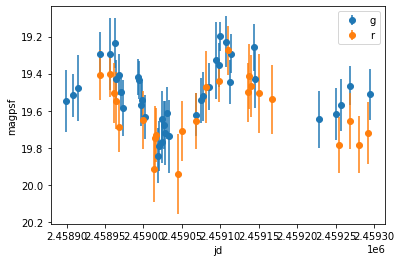

In [6]:
import matplotlib.pyplot as plt
dic_flt = {1:"g", 2:"r", 3:"i"}
filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
for flt in [1,2]:
    df_byflt = single_object[single_object['i:fid']==flt]
    plt.errorbar(df_byflt['i:jd'], df_byflt['i:magpsf'], yerr=df_byflt['i:sigmapsf'],fmt='o',label=dic_flt[flt])
plt.xlabel('jd')
plt.ylabel('magpsf')
plt.legend()
plt.gca().invert_yaxis()
# plt.show()

# 2nd case study: early supernovae candidates
Early supernova candidates is a tag provided by Fink. It requires that the alert has no known transient association (from catalogues), it is relatively new (number of previous detections< 10) and when both a [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173) trained to identify SNe Ia or SNe and a Random Forest Leoti et al. in prep. based on [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract) trained to select early supernovae have a probability higher than 50% of this object being a SN.

### API query: latest alerts which are early supernovae candidates

In [7]:
# Get latests 5 Early SN candidates
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': 'Early SN candidate',
    'n': '50'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

### Analysing the output: color of these alerts (if g and r measurements in the same night)
This color is an added value by Fink if there is photmetry in a single night for two filters

In [8]:
candSNe_w_color = pdf[(~pdf["v:r-g"].isna())]
candSNe_w_color

,d:cdsxmatch,d:mulens_class_1,d:mulens_class_2,d:rfscore,d:roid,d:snn_sn_vs_all,d:snn_snia_vs_nonia,i:candid,i:chipsf,i:classtar,...,i:ssdistnr,i:ssmagnr,i:ssnamenr,i:tooflag,i:xpos,i:ypos,v:classification,v:r-g,v:rate(r-g),v:lastdate
0,Unknown,,,0.827,0,0.932730,0.835596,1540392174815015010,2.227138,0.940,...,-999,-999,null,0,2029.0638,2012.7988,Early SN candidate,-0.516015,NaN,2021-03-21 09:24:43.998
1,Unknown,,,0.736,0,0.443652,0.828649,1540281452715015002,2.652678,0.982,...,-999,-999,null,0,2901.7036,2658.6190,Early SN candidate,-0.157648,NaN,2021-03-21 06:45:17.997
3,Unknown,,,0.724,0,0.842707,0.770351,1540231092715015008,2.327265,0.981,...,-999,-999,null,0,2904.7360,2658.3430,Early SN candidate,-0.157648,NaN,2021-03-21 05:32:46.997
6,Unknown,,,0.806,0,0.560578,0.751676,1538476535815015005,7.268067,0.991,...,-999,-999,null,0,1525.3207,454.7714,Early SN candidate,-0.516015,NaN,2021-03-19 11:26:13.004
8,Unknown,,,0.728,0,0.618928,0.817308,1538453155815015005,5.223951,1.000,...,-999,-999,null,0,1535.3995,443.3110,Early SN candidate,-0.516015,NaN,2021-03-19 10:52:32.998
11,Unknown,,,0.524,0,0.369381,0.886134,1538238393415015002,1.498259,0.983,...,-999,-999,null,0,1920.6842,556.2155,Early SN candidate,-0.171869,NaN,2021-03-19 05:43:17.000
16,Unknown,,,0.630,0,0.870432,0.792498,1536425751815015001,1.394083,0.979,...,-999,-999,null,0,1734.0835,206.4354,Early SN candidate,-0.450946,NaN,2021-03-17 10:13:04.999
17,Unknown,,,0.596,0,0.236306,0.872344,1536420113015015002,108.736230,0.994,...,-999,-999,null,0,1468.5269,255.6330,Early SN candidate,0.069406,NaN,2021-03-17 10:04:57.996
18,Unknown,,,0.630,0,0.811711,0.786578,1536390641815015000,1.478079,0.988,...,-999,-999,null,0,1726.9340,199.0248,Early SN candidate,-0.450946,NaN,2021-03-17 09:22:31.996
19,Unknown,,,0.858,0,0.292554,0.743529,1536357974015015008,3.634163,0.983,...,-999,-999,null,0,3025.5093,1694.3492,Early SN candidate,-0.102220,NaN,2021-03-17 08:35:28.997


### Analysing the output: select alerts with color <0.5

In [9]:
candSNe_w_color[candSNe_w_color["v:r-g"]<-0.5][['i:objectId',"v:r-g"]]

,i:objectId,v:r-g
0,ZTF21aaobcrz,-0.516015
6,ZTF21aaobcrz,-0.516015
8,ZTF21aaobcrz,-0.516015
22,ZTF21aamzuxi,-1.136025
23,ZTF21aamzuxi,-1.136025
42,ZTF21aalcsng,-1.239767
47,ZTF21aalcsng,-1.239767


### Analysing the output: select alerts with color <0.5 and brighter than magpsf 19 (either filter)
this brightness is the latest one, not a projection

In [10]:
bright_candSNe_w_color = candSNe_w_color[(candSNe_w_color["v:r-g"]<-0.5) & (candSNe_w_color["i:magpsf"]<19)]
bright_candSNe_w_color[["i:objectId","i:magpsf","v:r-g"]]

,i:objectId,i:magpsf,v:r-g
0,ZTF21aaobcrz,18.316492,-0.516015
6,ZTF21aaobcrz,18.151890,-0.516015
8,ZTF21aaobcrz,18.233145,-0.516015
22,ZTF21aamzuxi,18.317719,-1.136025
23,ZTF21aamzuxi,18.363598,-1.136025
42,ZTF21aalcsng,17.776602,-1.239767
47,ZTF21aalcsng,17.831366,-1.239767


### API query: get photometry for one high-probability alert with color <0.5 and brighter than magpsf 19 (either filter)
Supernova scores ar eobtained using SuperNNova trained in two different ways: 

In [14]:
# very high probability
high_prob_obj = bright_candSNe_w_color[(bright_candSNe_w_color['d:snn_sn_vs_all']>0.9) | (bright_candSNe_w_color['d:snn_snia_vs_nonia']>0.9)]['i:objectId'][0]

In [15]:
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': high_prob_obj,
    'output-format': 'json'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(r.content)

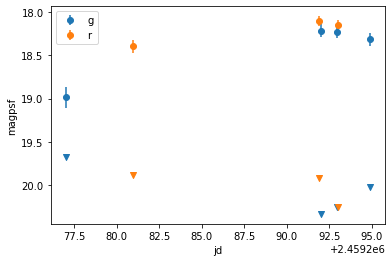

In [16]:
# import matplotlib.pyplot as plt
# dic_flt = {1:"g", 2:"r", 3:"i"}
# filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
for flt in [1,2]:
    df_byflt = single_object[single_object['i:fid']==flt]
    plt.errorbar(df_byflt['i:jd'], df_byflt['i:magpsf'], yerr=df_byflt['i:sigmapsf'],fmt='o',label=dic_flt[flt],color=filter_color[flt])
    plt.scatter(df_byflt['i:jd'],df_byflt['i:diffmaglim'],marker='v',color=filter_color[flt])
plt.xlabel('jd')
plt.ylabel('magpsf')
plt.gca().invert_yaxis()
plt.legend()

### Analysing the output: very high-probility alerts with color <0.5 and brighter than magpsf 19 (either filter)
Using SuperNNova classification modules

,d:cdsxmatch,d:mulens_class_1,d:mulens_class_2,d:rfscore,d:roid,d:snn_sn_vs_all,d:snn_snia_vs_nonia,i:candid,i:chipsf,i:classtar,...,i:ssdistnr,i:ssmagnr,i:ssnamenr,i:tooflag,i:xpos,i:ypos,v:classification,v:r-g,v:rate(r-g),v:lastdate
0,Unknown,,,0.827,0,0.93273,0.835596,1540392174815015010,2.227138,0.94,...,-999,-999,null,0,2029.0638,2012.7988,Early SN candidate,-0.516015,NaN,2021-03-21 09:24:43.998


# 3rd case study: type Ia supernovae in Fink
Type Ia supernovae recently classified and reported in TNS.

### API query: latest alerts associated with type Ia SNe

In [18]:
to do

SyntaxError: invalid syntax (<ipython-input-18-aef6d2462c89>, line 1)

### Analising the output: classification scores of these SNe

### Analising the output: SNe with close-by galaxies (not necessarily host-galaxies)